In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Sep  7 04:48:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers tokenizers -q

In [ ]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, DataCollatorWithPadding

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support

from collections import defaultdict
from textwrap import wrap

import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from tqdm import tqdm
import os

# Utils

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 8,6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pre_trained_model_ckpt = 'bert-base-uncased'

# Read Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/712 Project/train.En.csv")
df = df[df['tweet'].notna()]
df.head()

,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,multiclass_labels,label_encodings,unique_labels,label_counts,random_labels
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0,1,0,0,0,0,2,10000,0.0,2600.0,12.0
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1,0,0,0,0,0,4,100000,1.0,0.0,NaN
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0,1,0,0,0,0,2,10000,10.0,0.0,NaN
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1,0,0,0,0,0,4,100000,11.0,0.0,NaN
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1,0,0,0,0,0,4,100000,100.0,0.0,NaN


[Text(0, 0, 'Non-Sarcastic'), Text(1, 0, 'Sarcastic')]

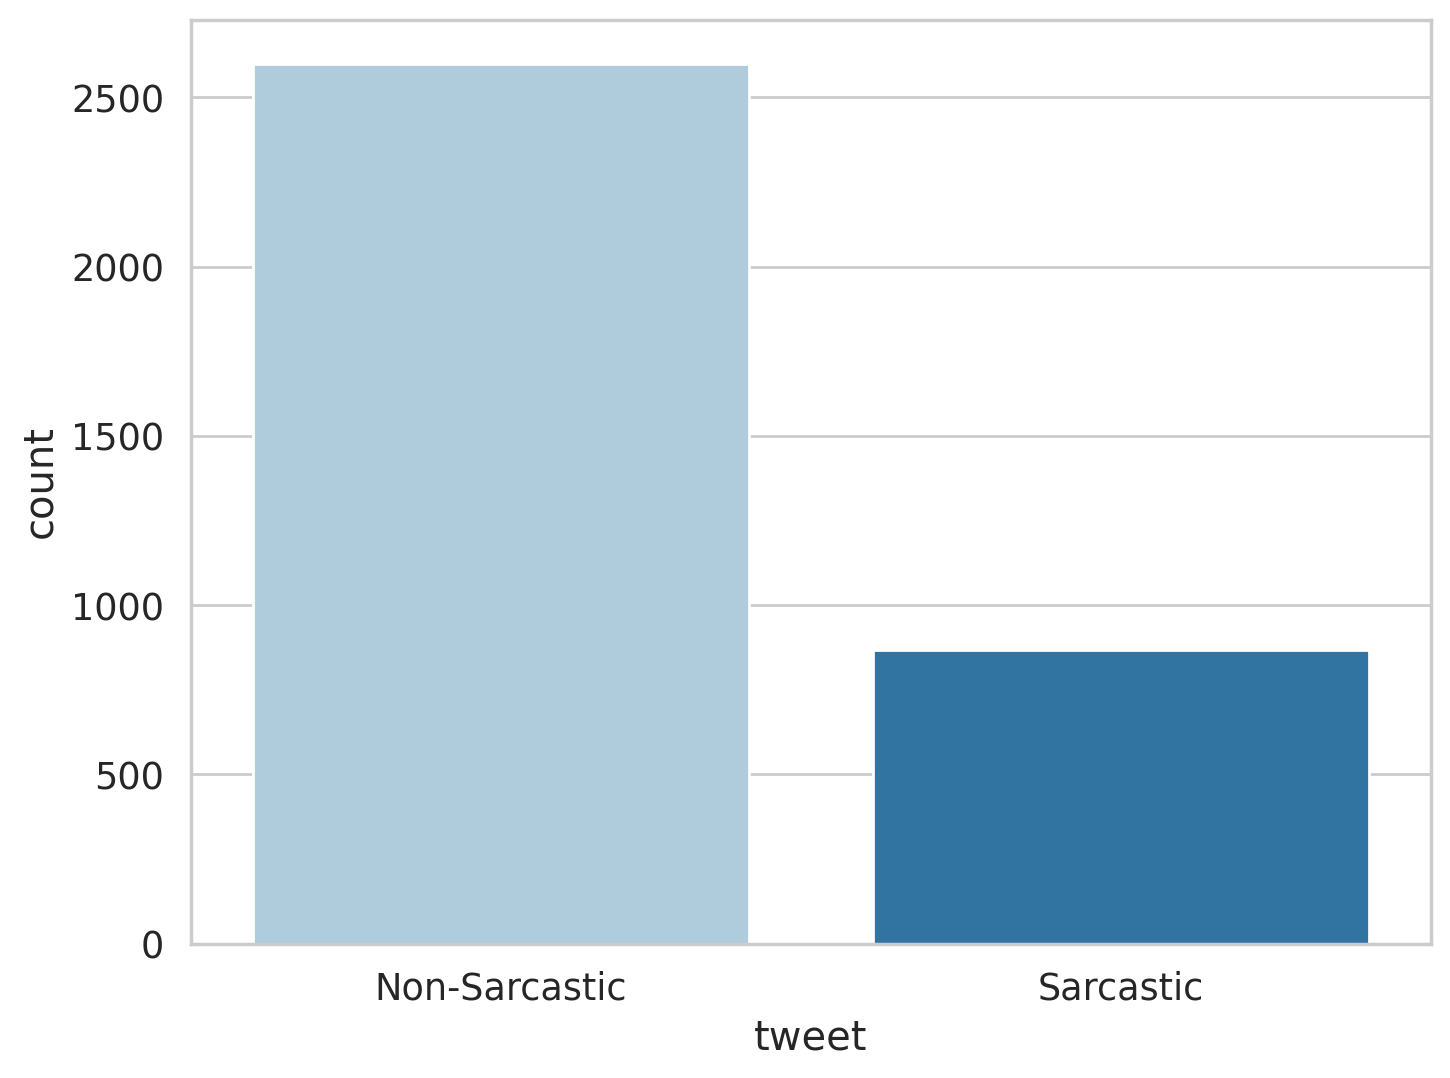

In [ ]:
class_names = ['Non-Sarcastic', 'Sarcastic']

ax = sns.countplot(data=df, x=df.sarcastic)
plt.xlabel('tweet')
# plt.xticks(rotation=45, ha='right')
ax.set_xticklabels(class_names)

## Define Transformer and Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

### EDA of token counts in the reviews dataset

In [ ]:
token_lens = []

for txt in df.tweet:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

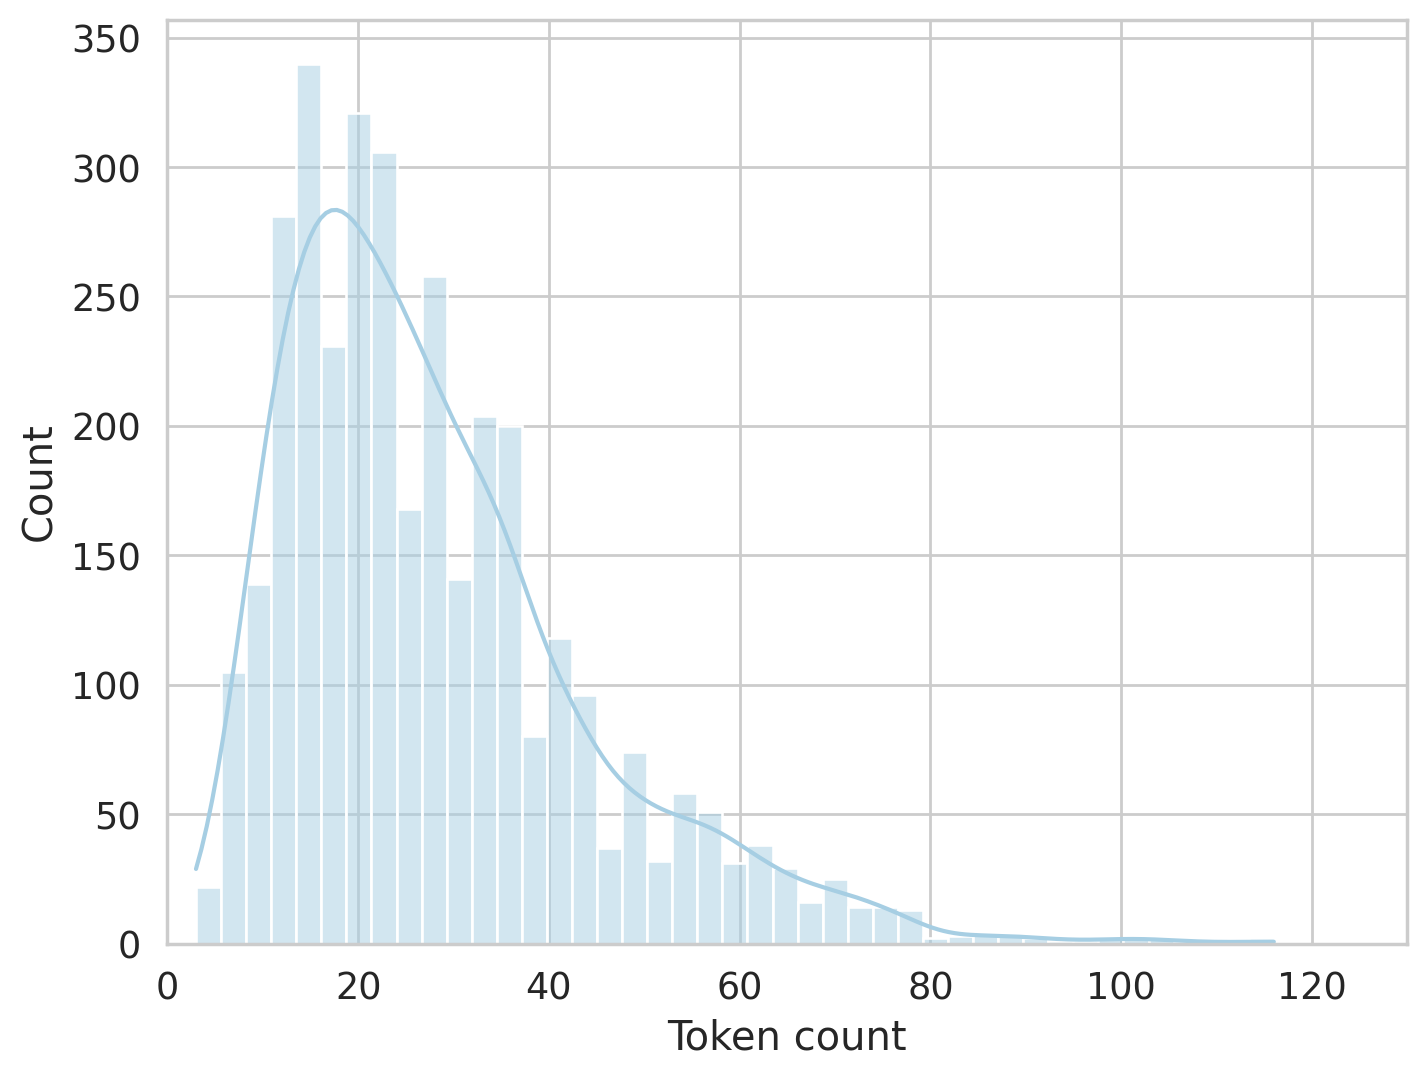

In [ ]:
sns.histplot(token_lens, kde=True)

plt.xlim([0,130])

plt.xlabel('Token count')

In [ ]:
df_train, df_val = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape)

(2426, 14) (1041, 14)


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/712 Project/task_A_En_test.csv")
df_test = df_test[df_test['text'].notna()]
print(df_test.shape)

(1400, 2)


# Dataloader

In [ ]:
MAX_LEN = 512
BATCH_SIZE = 16

class SarcasmDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            padding = 'max_length',
            return_tensors = 'pt',)

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        if self.include_raw_text:
            output['review_text'] = review

        return output

tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = 'max_length')

def create_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_text = False ):
    ds = SarcasmDataset(
        reviews=df.tweet.to_list(),
        targets = df.sarcastic.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text
    )
    return DataLoader(ds, batch_size=batch_size, collate_fn=collator )

def create_test_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_text = False ):
    ds = SarcasmDataset(
        reviews=df.text.to_list(),
        targets = df.sarcastic.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text
    )
    return DataLoader(ds, batch_size=batch_size, collate_fn=collator )

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=False)
test_data_loader = create_test_data_loader(df_test, tokenizer, include_raw_text=False)

In [ ]:
# for d in val_data_loader:
#     print(d.keys())

# dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

In [ ]:
#Testing to see if the data loader works appropriately
data = next(iter(test_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'])

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


# Model Utility Class

In [ ]:
class SarcasticTextClassifier(nn.Module):
    """
    Sarcastic Text classification model based on BERT.

    Args:
        n_classes (int): Number of classes for sarcastic text classification.

    """
    def __init__(self, n_classes):
        super(SarcasticTextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_ckpt,return_dict=False)
        self.drop = nn.Dropout(p = 0.3)
        self.nn1 = nn.Linear(self.bert.config.hidden_size, 400)
        self.nn2 = nn.Linear(400, 150)
        self.out = nn.Linear(150, n_classes) # BERT returns tensors of length 768

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the sentiment classifier model.

        Args:
            input_ids (torch.Tensor): Input tensor of shape (batch_size, sequence_length).
            attention_mask (torch.Tensor): Attention mask tensor of shape (batch_size, sequence_length).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_classes).

        """
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )
        # print(pooled_output.shape)
        output = self.drop(pooled_output)
        interim = F.relu(self.nn2(F.selu(self.nn1(output))))
        return self.out(interim)

In [ ]:
from torchsummary import summary

In [ ]:
model = SarcasticTextClassifier(len(class_names))
model = model.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total__trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total number of parameters: {}'.format(pytorch_total_params))
print('total number of trainable parameters: {}'.format(pytorch_total__trainable_params))

# summary(model, (BATCH_SIZE, 512))

# # An evaluation run of the model
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# F.softmax(model(input_ids,attention_mask), dim = 1)


total number of parameters: 109850292
total number of trainable parameters: 109850292


# Training

## Training Loop Utility Functions

In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Trains the given model using the provided data loader and optimizer.

    Args:
        model (torch.nn.Module): Model to train.
        data_loader (DataLoader): DataLoader providing the training data.
        loss_fn: Loss function to optimize.
        optimizer: Optimizer for updating the model's parameters.
        device: Device to use for training.
        scheduler: Learning rate scheduler.
        n_examples (int): Total number of training examples.

    Returns:
        float: Accuracy of the model on the training data.
        float: Average training loss.

    """
    model=model.train()
    losses = []
    correct_predictions = 0

    accuracy, f1, PRECISION, RECALL = 0, 0, 0, 0
    epsilon = 1e-7

    loop = tqdm(data_loader, total=len(data_loader), leave=False)

    """  iterate over the batches provided by the data loader. Within each iteration, the batch tensors are moved to the appropriate device. The model performs a forward pass on the input tensors, and the predicted labels are obtained by taking the maximum value along the appropriate dimension. """
    for d in loop:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        # print(f'targets: {targets}')
        # print(f'predictions: {preds}')
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets).cpu()

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # update tqdm loop
        # loop.set_postfix(loss=loss.item())

        precision, recall, fscore, _ = precision_recall_fscore_support(np.array(targets.detach().cpu()), np.array(preds.detach().cpu()), average='macro', zero_division=0.0)

        PRECISION += precision
        RECALL += recall
        f1 += fscore

    # return correct_predictions/n_examples, np.mean(losses)
    return correct_predictions/n_examples, np.mean(losses), f1/len(data_loader), PRECISION/len(data_loader), RECALL/len(data_loader)

''' clip_grad_norm - We tackle the problem of exploding and vanishing gradients By gradient clipping '''


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    accuracy, f1, PRECISION, RECALL = 0, 0, 0, 0
    epsilon = 1e-7

    loop = tqdm(data_loader, total=len(data_loader), leave=False)
    with torch.no_grad():
        for d in loop:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets.detach())
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())

            # update tqdm loop
            loop.set_postfix(loss=loss.item())

            precision, recall, fscore, _ = precision_recall_fscore_support(np.array(targets.detach().cpu()), np.array(preds.detach().cpu()), average='macro', zero_division=0.0)

            PRECISION += precision
            RECALL += recall
            f1 += fscore

    # return correct_predictions/n_examples, np.mean(losses)
    return correct_predictions/n_examples, np.mean(losses), f1/len(data_loader), PRECISION/len(data_loader), RECALL/len(data_loader)

# Model Evaluation on test_data_loader
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    real_values = []
    predictions2 = []

    with torch.no_grad():
        for i,d in enumerate(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            _, preds2 = torch.max(probs, dim =1)
            predictions2.extend(preds2)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    predictions2 = torch.stack(predictions2).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values, predictions2

In [ ]:
EPOCHS = 2

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps)


loss_fn = nn.CrossEntropyLoss().to(device)

LOAD_MODEL = False
weight_dir = "/content/drive/MyDrive/712 Project/weights"

In [ ]:
def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint)
  print("checkpoint loaded!")

In [ ]:
import os

## Training Loop

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
best_f1 = 0

if LOAD_MODEL:
  checkpoint = torch.load(os.path.join(weight_dir,'best_model_state_Task1.pth.tar'))
  load_checkpoint(checkpoint, model)

print('Initiating/Resuming Training...')

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    print('-'*30)
    # train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    # print(f'Train loss {train_loss} accuracy {train_acc}')
    train_acc, train_loss, train_f1, train_precision, train_recall = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train Metrics: loss = {train_loss}, Accuracy = {train_acc}, F1 = {train_f1}, Precision = {train_precision}, Recall = {train_recall}')

    # val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    # print(f'Val loss {val_loss} accuracy {val_acc}')
    val_acc, val_loss, val_f1, val_precision, val_recall = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val Metrics: Loss = {val_loss}, Accuracy = {val_acc}, F1 = {val_f1}, Precision = {val_precision}, Recall = {val_recall}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    history['train_precision'].append(train_precision)
    history['train_f1'].append(train_f1)
    history['train_recall'].append(train_recall)
    history['val_precision'].append(val_precision)
    history['val_f1'].append(val_f1)
    history['val_recall'].append(val_recall)

    if val_acc>best_accuracy and val_f1>best_f1:
        torch.save(model.state_dict(), os.path.join(weight_dir,'best_model_state_Task1.pth.tar'))
        print(f"=> Just saved checkpoint for epoch : {epoch+1}")
        best_accuracy = val_acc
        best_f1 = val_f1

Initiating/Resuming Training...
Epoch 1 / 2
------------------------------


Train Metrics: loss = 0.5600779803567811, Accuracy = 0.7580379247665405, F1 = 0.4337191949050158, Precision = 0.3854675751879699, Recall = 0.5025318020794994


Val Metrics: Loss = 0.6049265432538409, Accuracy = 0.7243035435676575, F1 = 0.41134998023876135, Precision = 0.35700757575757575, Recall = 0.49242424242424243
=> Just saved checkpoint for epoch : 1
Epoch 2 / 2
------------------------------


Train Metrics: loss = 0.5405387664703947, Accuracy = 0.7609233260154724, F1 = 0.43661643210352336, Precision = 0.3870888157894737, Recall = 0.506578947368421


Val Metrics: Loss = 0.5987148415861707, Accuracy = 0.7243035435676575, F1 = 0.41134998023876135, Precision = 0.35700757575757575, Recall = 0.49242424242424243
CPU times: user 7min 53s, sys: 1.62 s, total: 7min 54s
Wall time: 8min 43s


# Model Evaluation

In [ ]:
checkpoint = torch.load(os.path.join(weight_dir,'best_model_state_Task1.pth.tar'))
load_checkpoint(checkpoint, model)

y_pred, y_pred_probs, y_test, y_pred2 = get_predictions(model, test_data_loader)
precision, recall, fscore, _ = precision_recall_fscore_support(np.array(y_test), np.array(y_pred2), average='micro', zero_division=0.0)
print(f"Test precision: {precision}")
print(f"Test recall: {recall}")
print(f"Test F1: {fscore}")

=> Loading checkpoint
checkpoint loaded!
Test precision: 0.8571428571428571
Test recall: 0.8571428571428571
Test F1: 0.8571428571428571


In [ ]:
tweet = "Love it when I get disturbed three times in the bath to be asked where things in the house are!!"
encoded_review = tokenizer.encode_plus(tweet, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, padding='max_length', return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(F.softmax(output, dim=1), dim=1)

print(f'Tweet: {tweet}')
print(f'Class: {class_names[prediction]}')


Tweet: Love it when I get disturbed three times in the bath to be asked where things in the house are!!
Class: Non-Sarcastic
